In [1]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "pytorch" # v2
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf"

# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

print(os.environ['DDE_BACKEND'])

pytorch


In [2]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     print(device)

import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')

import deepxde as dde
import numpy as np
from numpy import linalg as LA
import math

import matplotlib.pyplot as plt
import pylab

from os.path import dirname, join as pjoin

from scipy import stats
import scipy.io
from scipy.stats import truncnorm, norm
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp
    
import cvxpy as cp
import numpy as np
import tensorflow as tf
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm

# from cvxpylayers.tensorflow.cvxpylayer import CvxpyLayer
from cvxpylayers.torch import CvxpyLayer



print(time.time())

Using backend: pytorch



True
1
NVIDIA RTX A2000 Laptop GPU
11.3
True
0


2022-09-11 11:05:10.357298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 11:05:10.438412: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-11 11:05:10.457659: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-11 11:05:10.786764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1662919511.194495


In [5]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
N = nSample = 100

# must be floats
state_min = 0.0
state_max = 6.0

mu_0 = 5.0
sigma_0 = 1.0

mu_T = 4.0
sigma_T = 1.0

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

id_prefix = nb_name.replace(".ipynb", "").replace("-", "_")

print(id_prefix)
print(time.time())

wass_1d_torch
1662919517.264773


In [7]:
def pdf1d(x, mu, sigma):
    a, b = (state_min - mu) / sigma, (state_max - mu) / sigma
    rho_x=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)

    # do NOT use gaussian norm, because it is only area=1
    # from -inf, inf, will not be for finite state/grid
    # rho_x = norm.pdf(x, mu, sigma)
    return rho_x

def boundary(_, on_initial):
    return on_initial

print(time.time())

1662919520.9763598


In [8]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)
print(time.time())

1662919523.6325867


In [9]:
# 1d linprog example

rho_0_1d=pdf1d(x_T, 5.0, 1.0).reshape(len(x_T),1)
rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)
rho_0_1d = rho_0_1d / np.sum(np.abs(rho_0_1d))
# rho_0_1d  /= np.trapz(rho_0_1d, x=x_T, axis=0)[0]

rho_T_1d=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)
rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)
rho_T_1d = rho_T_1d / np.sum(np.abs(rho_T_1d))
# rho_T_1d  /= np.trapz(rho_T_1d, x=x_T, axis=0)[0]

# normalizing by l1-norm works, by trapz does not

rho_0 = rho_0_1d
rho_T = rho_T_1d

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    bounds=[(0, np.inf)],
    options={"disp": True}
)
print(res.fun)

print(time.time())

Running HiGHS 1.2.2 [date: 2022-08-26, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0.6318734471629914
1662919525.520148
Presolving model
200 rows, 10000 cols, 20000 nonzeros
199 rows, 10000 cols, 19900 nonzeros
Presolve : Reductions: rows 199(-1); columns 10000(-0); elements 19900(-100)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 199(1.99666) 0s
       2699     6.3187344716e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2699
Objective value     :  6.3187344716e-01
HiGHS run time      :          0.11


In [10]:
S3 = dde.Variable(1.0)
a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005
K, T=1.38066*10**-23, 293.

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here
    Including a penalty function for negative solutions
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*torch.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
#     dD2_x=dde.grad.jacobian(D2, x, j=0)
#     dF_x=dde.grad.jacobian(F, x, j=0)
#     D1=dD2_x-dF_x*(D2/(K*T))
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*torch.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100

    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
#         neg_loss,
#         neg_loss_y2,
    ]


print(time.time())

1662919530.2761014


In [24]:
# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)
pred = cp.Parameter((A.shape[0],))
problem = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == pred,
    ],
)
assert problem.is_dpp()
cvxpylayer = CvxpyLayer(
    problem,
    parameters=[pred],
    variables=[x])

rho_0_tensor = torch.from_numpy(
    rho_0
).requires_grad_(False)

cvector_tensor = torch.from_numpy(
    cvector.reshape(-1)
).requires_grad_(False)

'''
rho_0_tensor = rho_0_tensor.to(cpu)
cvector_tensor = cvector_tensor.to(cpu)
print(type(rho_0_tensor))
def rho0_WASS_cpu(y_true, y_pred):
#     y_pred = y_pred.to(cpu)
#     y_pred = y_pred.cpu()
    
    y_pred = torch.where(y_pred < 0, 0, y_pred)
    y_pred = y_pred / torch.sum(torch.abs(y_pred))

    param = torch.cat((rho_0_tensor, y_pred), 0)
    param = torch.reshape(param, (2*N,))
    print(type(param))
    x_sol, = cvxpylayer(param)
    # TODO(handle infeasible)
    wass_dist = torch.matmul(cvector_tensor, x_sol)
    return wass_dist
'''

rho_0_tensor = rho_0_tensor.to(cuda0)
cvector_tensor = cvector_tensor.to(cuda0)

def rho0_WASS_cuda0(y_true, y_pred):
    y_pred = y_pred.to(cuda0)
    y_pred.retain_grad()

    y_pred = torch.where(y_pred < 0, 0, y_pred)
    y_pred = y_pred / torch.sum(torch.abs(y_pred))

    param = torch.cat((rho_0_tensor, y_pred), 0)
    param = torch.reshape(param, (2*N,))
    # print(type(param))
    x_sol, = cvxpylayer(param)
    # TODO(handle infeasible)
    wass_dist = torch.matmul(cvector_tensor, x_sol)
    wass_dist = torch.sqrt(wass_dist)
    return wass_dist

print(time.time())

1662920913.845493


In [25]:
geom = dde.geometry.Interval(state_min, state_max)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

print(time.time())

1662920915.5867922


In [26]:
time_0=np.hstack((x_T,T_0*np.ones((len(x_T), 1))))
rho_0=pdf1d(x_T, mu_0, sigma_0).reshape(len(x_T),1)
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(np.abs(rho_0))
print(np.trapz(rho_0, axis=0)[0])
print(np.sum(rho_0))
rho_0_BC = dde.icbc.PointSetBC(time_0, rho_0, component=1)

time_t=np.hstack((x_T,T_t*np.ones((len(x_T), 1))))
rho_T=pdf1d(x_T, mu_T, sigma_T).reshape(len(x_T),1)
rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(np.abs(rho_T))
print(np.trapz(rho_T, axis=0)[0])
print(np.sum(rho_T))
rho_T_BC = dde.icbc.PointSetBC(time_t, rho_T, component=1)

print(time.time())

0.9913593372441998
1.0
0.9983243734671607
0.9999999999999998
1662920917.151175


In [27]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [rho_0_BC,rho_T_BC],
    num_domain=5000,
    num_initial=500)

# 2 inputs: x + t
# 3 outputs: 3 eqs
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
# net.apply_output_transform(modify_output)
# net.apply_output_transform(modify_output)
model = dde.Model(data, net)

print(time.time())

1662920919.476188


In [28]:
ck_path = "%s/%s_model" % (os.path.abspath("./"), id_prefix)

class EarlyStoppingFixed(dde.callbacks.EarlyStopping):
    def on_epoch_end(self):
        current = self.get_monitor_value()
        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            # must meet baseline first
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = self.model.train_state.epoch
                self.model.stop_training = True
        else:
            self.wait = 0
                
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch))
        
        self.model.save(ck_path, verbose=True)

earlystop_cb = EarlyStoppingFixed(baseline=1e-3, patience=0)

print(time.time())

1662920921.8399165


In [29]:
loss_func=["MSE","MSE","MSE", rho0_WASS_cuda0,"MSE"]
# loss functions are based on PDE + BC: 3 eq outputs, 2 BCs

model.compile("adam", lr=1e-3,loss=loss_func)
losshistory, train_state = model.train(
    iterations=100,
    display_every=1,
    callbacks=[earlystop_cb])

Compiling model...
'compile' took 0.000113 s

Training model...

<class 'torch.Tensor'>
[tensor(0.0361, grad_fn=<MeanBackward0>), tensor(0.0103, grad_fn=<MeanBackward0>), tensor(0.3692, grad_fn=<MeanBackward0>), tensor(1.0352, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.1681, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0361, grad_fn=<MeanBackward0>), tensor(0.0103, grad_fn=<MeanBackward0>), tensor(0.3692, grad_fn=<MeanBackward0>), tensor(1.0352, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.1681, grad_fn=<MeanBackward0>)]
0         [3.61e-02, 1.03e-02, 3.69e-01, 1.04e+00, 1.68e-01]    [3.61e-02, 1.03e-02, 3.69e-01, 1.04e+00, 1.68e-01]    []  
<class 'torch.Tensor'>
[tensor(0.0361, grad_fn=<MeanBackward0>), tensor(0.0103, grad_fn=<MeanBackward0>), tensor(0.3692, grad_fn=<MeanBackward0>), tensor(1.0352, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.1681, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0003, grad_fn=<MeanBackward0>

[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0066, grad_fn=<MeanBackward0>), tensor(0.0093, grad_fn=<MeanBackward0>), tensor(0.8130, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0049, grad_fn=<MeanBackward0>)]
9         [1.11e-04, 6.59e-03, 9.29e-03, 8.13e-01, 4.91e-03]    [1.11e-04, 6.59e-03, 9.29e-03, 8.13e-01, 4.91e-03]    []  
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0066, grad_fn=<MeanBackward0>), tensor(0.0093, grad_fn=<MeanBackward0>), tensor(0.8130, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0049, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0071, grad_fn=<MeanBackward0>), tensor(0.0190, grad_fn=<MeanBackward0>), tensor(0.7697, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0172, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0071, grad_fn=<MeanBackward0>), tensor(0.0190, grad_fn=<MeanBackward0>), ten

<class 'torch.Tensor'>
[tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0032, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<MeanBackward0>), tensor(0.1299, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0010, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0027, grad_fn=<MeanBackward0>), tensor(0.0039, grad_fn=<MeanBackward0>), tensor(0.1644, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0033, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0027, grad_fn=<MeanBackward0>), tensor(0.0039, grad_fn=<MeanBackward0>), tensor(0.1644, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0033, grad_fn=<MeanBackward0>)]
19        [2.94e-04, 2.67e-03, 3.91e-03, 1.64e-01, 3.31e-03]    [2.94e-04, 2.67e-03, 3.91e-03, 1.64e-01, 3.31e-03]    []  
<class 'torch.Tensor'>
[tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0027, grad_fn=<MeanBackward0>), tensor(0.0039, grad_f

[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0024, grad_fn=<MeanBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>), tensor(0.1570, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0009, grad_fn=<MeanBackward0>)]
28        [1.45e-04, 2.39e-03, 6.90e-04, 1.57e-01, 9.22e-04]    [1.45e-04, 2.39e-03, 6.90e-04, 1.57e-01, 9.22e-04]    []  
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0024, grad_fn=<MeanBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>), tensor(0.1570, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0009, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(0.0017, grad_fn=<MeanBackward0>), tensor(0.1329, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0055, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(0.0017, grad_fn=<MeanBackward0>), ten

<class 'torch.Tensor'>
[tensor(9.7911e-05, grad_fn=<MeanBackward0>), tensor(0.0010, grad_fn=<MeanBackward0>), tensor(0.0006, grad_fn=<MeanBackward0>), tensor(0.1368, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0046, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0009, grad_fn=<MeanBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.1356, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0047, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0009, grad_fn=<MeanBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.1356, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0047, grad_fn=<MeanBackward0>)]
38        [1.01e-04, 9.27e-04, 7.71e-04, 1.36e-01, 4.73e-03]    [1.01e-04, 9.27e-04, 7.71e-04, 1.36e-01, 4.73e-03]    []  
<class 'torch.Tensor'>
[tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0009, grad_fn=<MeanBackward0>), tensor(0.0008, gr

[tensor(6.5560e-05, grad_fn=<MeanBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.0010, grad_fn=<MeanBackward0>), tensor(0.1542, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>)]
47        [6.56e-05, 7.83e-04, 9.86e-04, 1.54e-01, 7.39e-04]    [6.56e-05, 7.83e-04, 9.86e-04, 1.54e-01, 7.39e-04]    []  
<class 'torch.Tensor'>
[tensor(6.5560e-05, grad_fn=<MeanBackward0>), tensor(0.0008, grad_fn=<MeanBackward0>), tensor(0.0010, grad_fn=<MeanBackward0>), tensor(0.1542, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.8526e-05, grad_fn=<MeanBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<MeanBackward0>), tensor(0.1263, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0018, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.8526e-05, grad_fn=<MeanBackward0>), tensor(0.0007, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<Mean

<class 'torch.Tensor'>
[tensor(5.8910e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0011, grad_fn=<MeanBackward0>), tensor(0.1443, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0030, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.7886e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0022, grad_fn=<MeanBackward0>), tensor(0.1604, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0021, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.7886e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0022, grad_fn=<MeanBackward0>), tensor(0.1604, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0021, grad_fn=<MeanBackward0>)]
57        [5.79e-05, 3.66e-04, 2.23e-03, 1.60e-01, 2.07e-03]    [5.79e-05, 3.66e-04, 2.23e-03, 1.60e-01, 2.07e-03]    []  
<class 'torch.Tensor'>
[tensor(5.7886e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tenso

[tensor(5.1362e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(0.3686, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0082, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.1362e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(0.3686, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0082, grad_fn=<MeanBackward0>)]
66        [5.14e-05, 4.29e-04, 2.53e-03, 3.69e-01, 8.23e-03]    [5.14e-05, 4.29e-04, 2.53e-03, 3.69e-01, 8.23e-03]    []  
<class 'torch.Tensor'>
[tensor(5.1362e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(0.3686, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0082, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.4008e-05, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.0018, grad_fn=<Mean

[tensor(5.1789e-05, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.2941, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0043, grad_fn=<MeanBackward0>)]
75        [5.18e-05, 5.28e-04, 2.73e-04, 2.94e-01, 4.28e-03]    [5.18e-05, 5.28e-04, 2.73e-04, 2.94e-01, 4.28e-03]    []  
<class 'torch.Tensor'>
[tensor(5.1789e-05, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.2941, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0043, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.0697e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.2292, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0015, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(5.0697e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<Mean

<class 'torch.Tensor'>
[tensor(4.1920e-05, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0011, grad_fn=<MeanBackward0>), tensor(0.1634, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(4.0666e-05, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0019, grad_fn=<MeanBackward0>), tensor(0.1254, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0020, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(4.0666e-05, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0019, grad_fn=<MeanBackward0>), tensor(0.1254, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0020, grad_fn=<MeanBackward0>)]
85        [4.07e-05, 3.39e-04, 1.87e-03, 1.25e-01, 1.99e-03]    [4.07e-05, 3.39e-04, 1.87e-03, 1.25e-01, 1.99e-03]    []  
<class 'torch.Tensor'>
[tensor(4.0666e-05, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tenso

[tensor(3.6454e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<MeanBackward0>), tensor(0.1242, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0016, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(3.6454e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<MeanBackward0>), tensor(0.1242, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0016, grad_fn=<MeanBackward0>)]
94        [3.65e-05, 3.54e-04, 2.30e-03, 1.24e-01, 1.63e-03]    [3.65e-05, 3.54e-04, 2.30e-03, 1.24e-01, 1.63e-03]    []  
<class 'torch.Tensor'>
[tensor(3.6454e-05, grad_fn=<MeanBackward0>), tensor(0.0004, grad_fn=<MeanBackward0>), tensor(0.0023, grad_fn=<MeanBackward0>), tensor(0.1242, dtype=torch.float64, grad_fn=<SqrtBackward0>), tensor(0.0016, grad_fn=<MeanBackward0>)]
<class 'torch.Tensor'>
[tensor(3.1407e-05, grad_fn=<MeanBackward0>), tensor(0.0003, grad_fn=<MeanBackward0>), tensor(0.0022, grad_fn=<Mean

Saving loss history to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/loss.dat ...
Saving training data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/train.dat ...
Saving test data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/test.dat ...


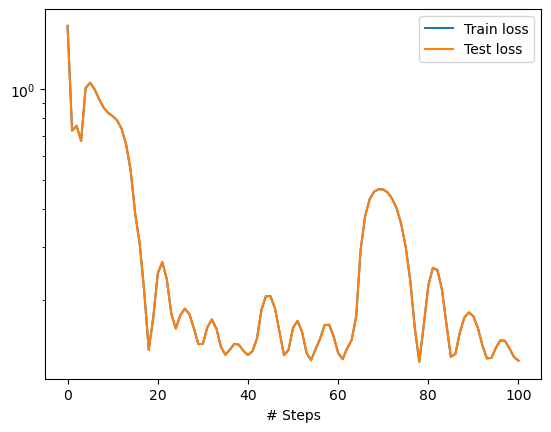

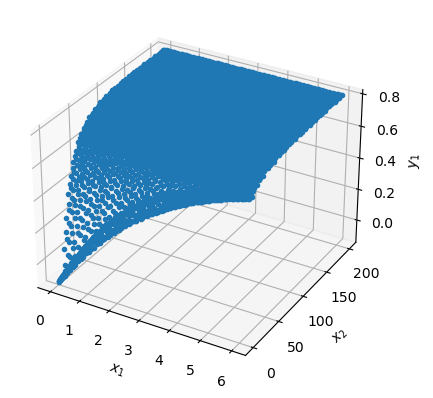

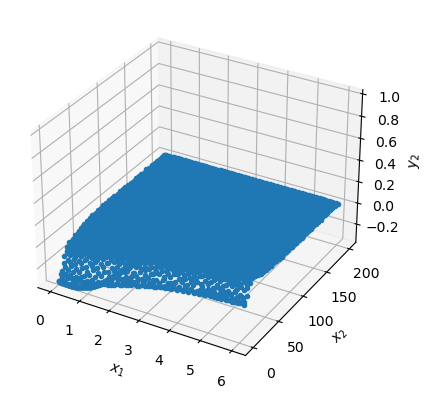

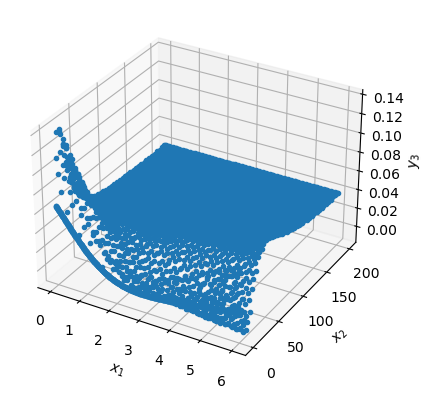

/usr/local/home/cyan3/Dev/jim/gradschool/231/research/wass_1d_torch_model-100.pt


In [30]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
model_path = model.save(ck_path)
print(model_path)

In [31]:
params = {'backend': 'ps',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.handlelength': 1,
          'legend.borderaxespad': 0,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
plt.style.use('seaborn-white')

loss_loaded [[  0.      0.036   0.01  ...   0.369   1.035   0.168]
 [  1.      0.      0.006 ...   0.046   0.672   0.004]
 [  2.      0.      0.004 ...   0.031   0.706   0.015]
 ...
 [ 98.      0.      0.    ...   0.      0.135   0.002]
 [ 99.      0.      0.    ...   0.      0.125   0.003]
 [100.      0.      0.    ...   0.001   0.121   0.003]]
saved plot


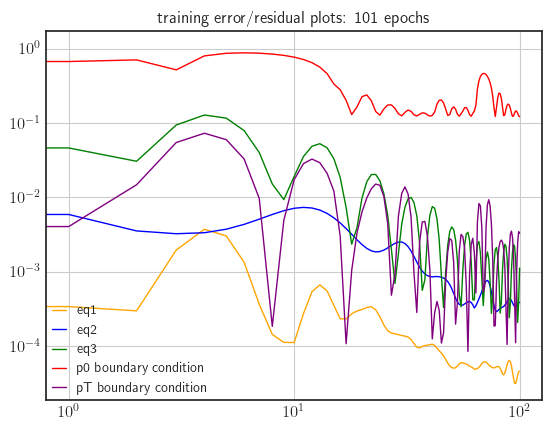

In [32]:
# 16 plot loss

loss_loaded = np.genfromtxt('./loss.dat')

print("loss_loaded", loss_loaded)

# import ipdb; ipdb.set_trace();

# [0] epoch
# [1] y1, psi, hjb
# [2] y2, rho, plank pde
# [3] rho0, initial
# [4] rhoT, terminal

epoch = loss_loaded[:, 0]
y1_psi_hjb = loss_loaded[:, 1]
y2_rho_plankpde = loss_loaded[:, 2]
loss3 = loss_loaded[:, 3]
rho0_initial = loss_loaded[:, 4]
rhoT_terminal = loss_loaded[:, 5]

fig, ax = plt.subplots()


line1, = ax.plot(epoch, y1_psi_hjb, color='orange', lw=1, label='eq1')
line2, = ax.plot(epoch, y2_rho_plankpde, color='blue', lw=1, label='eq2')
line2, = ax.plot(epoch, loss3, color='green', lw=1, label='eq3')
line3, = ax.plot(epoch, rho0_initial, color='red', lw=1, label='p0 boundary condition')
line4, = ax.plot(epoch, rhoT_terminal, color='purple', lw=1, label='pT boundary condition')

ax.grid()
ax.legend(loc="lower left")
ax.set_title('training error/residual plots: %d epochs' % (len(epoch)))
ax.set_yscale('log')
ax.set_xscale('log')

plot_fname = "%s/loss.png" % (os.path.abspath("./"))
plt.savefig(plot_fname, dpi=300)
print("saved plot")

plt.show()

In [34]:
T_IDX = 1
X_IDX = 0
EQ_IDX = 3

In [35]:
# 18 load test data

test = np.genfromtxt('./test.dat')
# test_timesorted = test[test[:, 3].argsort()]
# sort AGAIN by output because a lot of samples @ t=0, t=5
ind = np.lexsort((test[:,EQ_IDX],test[:,T_IDX])) # sorts by [1] (t) then by [3] (rho_0)
test_timesorted = test[ind]
source_t = test_timesorted[:, 1]

print(test_timesorted)

[[  0.328   0.     -0.03   -0.346   0.053]
 [  0.316   0.     -0.034  -0.346   0.054]
 [  0.34    0.     -0.027  -0.346   0.053]
 ...
 [  5.879 200.      0.806   0.021   0.039]
 [  5.939 200.      0.806   0.021   0.039]
 [  6.    200.      0.806   0.021   0.039]]


[[ 0.     0.    -0.128 -0.341  0.066]
 [ 5.262  0.     0.729  0.849  0.011]
 [ 0.387  0.    -0.013 -0.346  0.051]
 ...
 [ 0.656  0.     0.065 -0.338  0.04 ]
 [ 3.656  0.     0.612  0.407  0.003]
 [ 5.906  0.     0.759  0.991  0.014]]


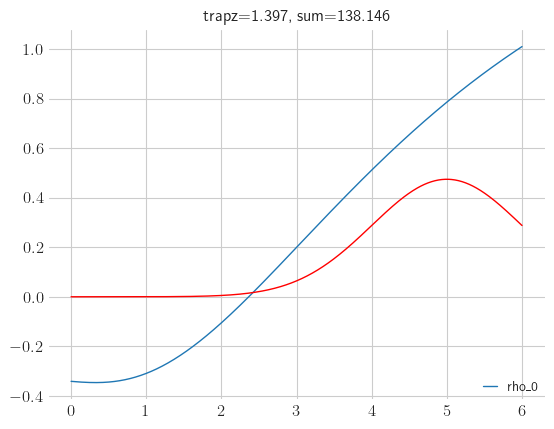

In [40]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

print(test_ti)

ind = np.lexsort((test_ti[:,EQ_IDX],test_ti[:,0])) # sorts by [1] (t) then by [3] (rho_0)
test_ti = test_ti[ind]

s1 = np.trapz(test_ti[:,EQ_IDX], axis=0, x=test_ti[:,X_IDX])
s2 = np.sum(test_ti[:,EQ_IDX])

fig = plt.figure(1)
ax1 = plt.subplot(111, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('trapz=%.3f, sum=%.3f' % (s1, s2))

ax1.plot(
    test_ti[:, 0],
    test_ti[:, EQ_IDX],
    linewidth=1,
    label='rho_0')
ax1.legend(loc='lower right')

test_rho0=pdf1d(test_ti[:, 0], 5.0, 1.0).reshape(test_ti.shape[0],1)
ax1.plot(
    test_ti[:, 0],
    test_rho0,
    c='r',
    linewidth=1,
    label='rho_0')

plt.show()

In [ ]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

ti_rho_opt = test_ti[:, ]

ti_rho_opt = np.where(ti_rho_opt<0, 0, ti_rho_opt)

ti_x1_x2_x3 = test_ti[:, 0:3]

####################################################################

d = 0.0
x1 = np.linspace(state_min - d, state_max + d, N)
x2 = np.linspace(state_min - d, state_max + d, N)
x3 = np.linspace(state_min - d, state_max + d, N)
X1, X2, X3 = np.meshgrid(x1,x2,x3,copy=False) # each is NxNxN

rho_opt = np.zeros((N,N,N))

closest_1 = [(np.abs(x1 - ti_x1_x2_x3[i, 0])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_2 = [(np.abs(x2 - ti_x1_x2_x3[i, 1])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_3 = [(np.abs(x3 - ti_x1_x2_x3[i, 2])).argmin() for i in range(ti_x1_x2_x3.shape[0])]

# some transposing going on in some reshape
# swapping closest_1/2 works well
rho_opt[closest_1, closest_2, closest_3] = ti_rho_opt

####################################################################

# RHO_OPT = gd(
#   (ti_x1_x2_x3[:, 0], ti_x1_x2_x3[:, 1], ti_x1_x2_x3[:, 2]),
#   ti_rho_opt,
#   (X1, X2, X3),
#   method='linear')

####################################################################

x1_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[j, i, :], x=x3) # x3 slices for one x2 => R
            for i in range(len(x2))]) # x3 slices across all x2 => Rn
        , x=x2) # x2 slice for one x1 => R
for j in range(len(x1))])

x2_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, j, :], x=x3) # x3 slices for one x1 => R
            for i in range(len(x1))]) # x3 slices across all x1 => Rn
        , x=x1) # x1 slice for one x2 => R
for j in range(len(x2))])

x3_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, :, j], x=x2) # x2 slices for one x1 => R
            for i in range(len(x1))]) # x2 slices across all x1 => Rn
        , x=x1) # x1 slice for one x3 => R
for j in range(len(x3))])

####################################################################

# normalize all the pdfs so area under curve ~= 1.0
x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("prior to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

x1_marginal /= x1_pdf_area
x2_marginal /= x2_pdf_area
x3_marginal /= x3_pdf_area

print(x1_marginal.shape)

x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("after to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

fig = plt.figure(1)
ax1 = plt.subplot(131, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('x1 marginal')

ax2 = plt.subplot(132, frameon=False)
# ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('x2 marginal')

# ax3 = plt.subplot(133, frameon=False)

ax3 = plt.subplot(133, frameon=False)
# ax3.set_aspect('equal')
ax3.grid()
ax3.set_title('x3 marginal')

colors="rgbymkc"

i = 0
t_e = 0
ax1.plot(x1,
    x1_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax1.legend(loc='lower right')

ax2.plot(x2,
    x2_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax2.legend(loc='lower right')

ax3.plot(x3,
    x3_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax3.legend(loc='lower right')

fig.suptitle('t=%.2f' % (target_t), fontsize=16)

plt.show()

In [ ]:
rv0 = multivariate_normal([mu_0, mu_0, mu_0], sigma_0 * np.eye(3))
rvT = multivariate_normal([mu_T, mu_T, mu_T], sigma_T * np.eye(3))

def pdf3d_0(x,y,z):
    return rv0.pdf(np.hstack((x, y, z)))

def pdf3d_T(x,y,z):
    return rvT.pdf(np.hstack((x, y, z)))

print(time.time())

In [ ]:
# 3d linprog example, with bounds

rho_0=pdf3d_0(x_T,y_T,z_T).reshape(len(x_T),1)
rho_T=pdf3d_T(x_T,y_T,z_T).reshape(len(x_T),1)

# very important to make it solvable
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(rho_0)

rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(rho_T)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print("mu_0 %.3f to mu_T %.3f" % (mu_0, mu_T))
    print(np.sqrt(res.fun))

In [ ]:
def penalty(xpdf):
    p1 = 10 * (xpdf<0).sum()
    
    t = np.trapz(xpdf, axis=0)[0]
    p2 = 10 * np.abs(t - 1)
    return p1 + p2

def WASS(y_true, y_pred):
    xpdf = y_pred.numpy()

    xpdf = np.where(xpdf < 0, 0, xpdf)
    if np.sum(xpdf) > 1e-8:
        xpdf = xpdf / np.sum(xpdf)

    res = linprog(
        cvector,
        A_eq=A,
        b_eq=np.concatenate((xpdf, rho_0_1d), axis=0),
        options={"disp": False},
        bounds=[(0, np.inf)],
    )
    
    # we are cheating here, we are using tf.reduce_sum
    # so that tf system will like our output 'type'
    # but we are 0'ing the sum and adding our scalar cost
    cand = tf.reduce_sum(y_pred) * 0.0
    
    if res.fun is None:
        return np.inf + cand
    else:
        lin = np.sqrt(res.fun)
        pen = penalty(xpdf)
#         print("trapz %.3f, count %d, pen %.3f, lin %.3f" % (
#             np.trapz(xpdf, axis=0)[0],
#             (xpdf<0).sum(),
#             pen,
#             lin))
        return lin + cand + pen

def WASS2(y_true, y_pred):
    loss = tf.py_function(
        func=WASS,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

def Z(y_true, y_pred):
#     xpdf = y_pred.numpy()
    
#     t = np.trapz(xpdf, axis=0)[0]
#     p2 = 10 * np.abs(t - 1)
    
    cand = tf.abs(1 - tf.reduce_sum(y_pred))
    
    cand = cand + 100 * (0 - tf.reduce_min(y_pred))

    return cand

def Z2(y_true, y_pred):
    loss = tf.py_function(
        func=Z,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

print(time.time())